In [1]:
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import DataLoader
import tiktoken

from src.data_loader import load_data
from src.utils import load_config
from src import wikipedia_article_dataset
from src.models import CNN, CNNModel
from src.evaluation import evaluate_model

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [2]:
MAX_LENGTH = 400
BATCH_SIZE = 16

EMBEDDING_DIM = 128
NUM_FILTERS = 10
FILTER_SIZES = [3, 4, 5]
NUM_CLASSES = 2
DROPOUT = 0.5

In [3]:
config = load_config("just-load")

In [4]:
df = load_data(config["data_loader"], "binary")

In [5]:
df

,text,label
0,"The Windsor Locks, Connecticut tornado struck ...",0
1,The 2 18th Battalion was an Australian Army in...,0
2,The 2002 North Indian Ocean cyclone season was...,0
3,The 1905 Atlantic hurricane season featured fi...,0
4,David Agus is an American physician and author...,1
...,...,...
1995,Amaysim branded as amaysim is an Australian pr...,1
1996,The 1926 FA Cup Final was a football match bet...,0
1997,Charity number 1062448 Active Training and Edu...,1
1998,Agile Communication Environment ACE is an Avay...,1


In [6]:
X_train, X_test, y_train, y_test = train_test_split(list(df["text"]), list(df["label"]), test_size=0.2)

In [7]:
model = CNNModel(
    EMBEDDING_DIM,
    NUM_FILTERS,
    FILTER_SIZES,
    NUM_CLASSES,
    MAX_LENGTH,
    DROPOUT
)

In [8]:
model.fit(X_train, y_train, 0.001, 10, BATCH_SIZE)

Epoch: 0, loss: 0.7593963435292244
Epoch: 1, loss: 0.4722656720876694
Epoch: 2, loss: 0.4211538469791412
Epoch: 3, loss: 0.3447972508519888
Epoch: 4, loss: 0.29454032473266123
Epoch: 5, loss: 0.28412551354616883
Epoch: 6, loss: 0.23678777821362018
Epoch: 7, loss: 0.250951739307493
Epoch: 8, loss: 0.21284970697015523
Epoch: 9, loss: 0.2116305359452963


In [9]:
predictions = model.predict(X_test)

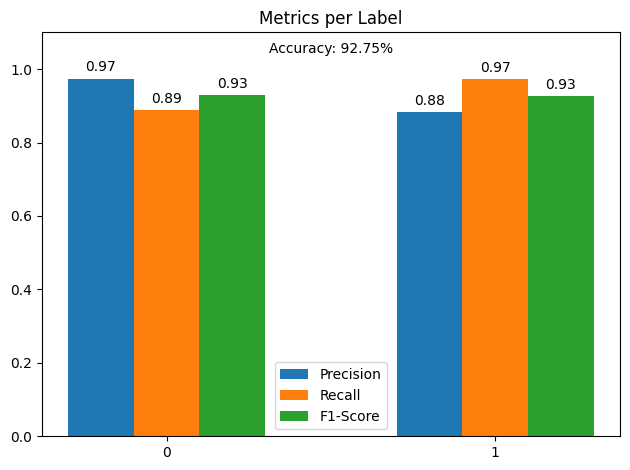

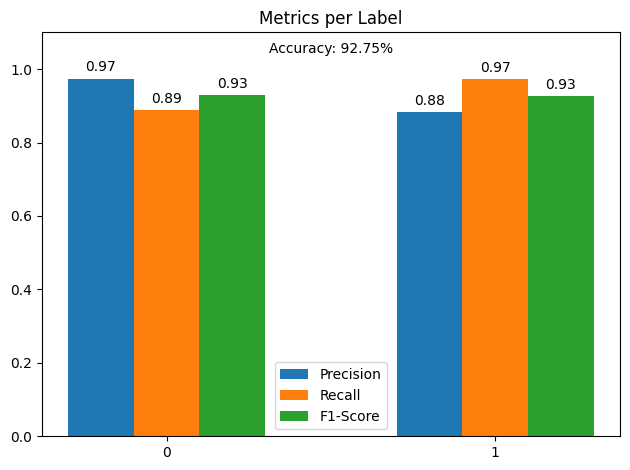

In [10]:
evaluate_model(model, X_test, y_test)